In [1]:
import pandas as pd
import numpy as np
import os
import tsfresh
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import tensorflow as tf

import os

import matplotlib.pyplot as plt

# keras goodies
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv1D, Dropout, MaxPooling1D, BatchNormalization
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras import metrics as kmetrics
import tensorflow.keras.backend as K

## Getting the data

In [3]:
data_path = '../data/'

In [4]:
final_sliding_windows = pd.read_csv(data_path + '/sliding_windows_smallest20_size20_step20.csv')

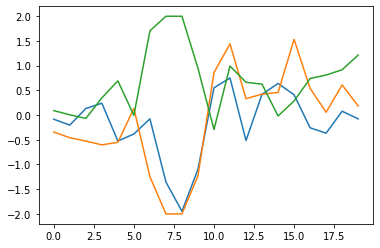

In [5]:
def plot_by_id(df, i): 
    plot_recording = df[df['recording_id'] == i]
    plot_recording = plot_recording.reset_index()
    plt.plot(plot_recording.index, plot_recording['accel_x'])
    plt.plot(plot_recording.index, plot_recording['accel_y'])
    plt.plot(plot_recording.index, plot_recording['accel_z'])
    
plot_by_id(final_sliding_windows, 'Respeck_s1865457_Falling on the back_30-09-2021_11-53-32')

## Split into training and test sets

Make sure to split by subject!

In [6]:
columns_of_interest = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']

In [7]:
# Simple for now
subjects = final_sliding_windows['subject_id'].unique()

train_subjects, test_subjects = train_test_split(subjects, test_size=0.2, train_size=0.8)

X_train_full = final_sliding_windows[final_sliding_windows['subject_id'].isin(train_subjects)][['window_id'] + columns_of_interest]
y_train_full = final_sliding_windows[final_sliding_windows['subject_id'].isin(train_subjects)][['window_id'] + ['activity_type']]

X_test_full = final_sliding_windows[final_sliding_windows['subject_id'].isin(test_subjects)][['window_id'] + columns_of_interest]
y_test_full = final_sliding_windows[final_sliding_windows['subject_id'].isin(test_subjects)][['window_id'] + ['activity_type']]


## Format the input

Format data into windows - make (50,6) inputs

In [8]:
class_labels = {
    'Sitting': 0,
    'Sitting bent forward': 1,
    'Sitting bent backward': 2,
    'Standing': 3,
    'Lying down left': 4,
    'Lying down right': 5,
    'Lying down on stomach': 6,
    'Lying down on back': 7,
    'Walking at normal speed': 8,
    'Running': 9,
    'Climbing stairs': 10,
    'Descending stairs': 11,
    'Desk work': 12,
    'Movement': 13,
    'Falling on knees': 14,
    'Falling on the back': 15,
    'Falling on the left': 16,
    'Falling on the right': 17
}

In [8]:
class_labels = {
    'Standing': 0,
    'Walking at normal speed': 1
}

In [9]:
# Keep only the classes of interest
X_train_full = X_train_full[y_train_full['activity_type'].isin(class_labels.keys())]
X_test_full = X_test_full[y_test_full['activity_type'].isin(class_labels.keys())]
y_train_full = y_train_full[y_train_full['activity_type'].isin(class_labels.keys())]
y_test_full = y_test_full[y_test_full['activity_type'].isin(class_labels.keys())]

# Create the y ones
y_train = y_train_full.groupby("window_id")[['activity_type']].agg(np.min).replace(class_labels)['activity_type'].values
y_test = y_test_full.groupby("window_id")[['activity_type']].agg(np.min).replace(class_labels)['activity_type'].values

y_train = np.asarray(pd.get_dummies(y_train), dtype=np.float32)
y_test = np.asarray(pd.get_dummies(y_test), dtype=np.float32)

In [10]:
X_train = []
X_test = []
    
for window_id, group in X_train_full.groupby('window_id'):
    #print(f"window_id = {window_id}")
    
    shape = group[columns_of_interest].values.shape
    #print(f"shape = {shape}")
    if shape == (20,6):
        X_train.append(group[columns_of_interest].values)
    
for window_id, group in X_test_full.groupby('window_id'):
    #print(f"window_id = {window_id}")
    
    shape = group[columns_of_interest].values.shape
    #print(f"shape = {shape}")
    
    X_test.append(group[columns_of_interest].values)
    
X_train = np.asarray(X_train)#, dtype=object)
X_test = np.asarray(X_test)#, dtype=object)

In [12]:
print(np.shape(X_train))
print(np.shape(X_test))

print(np.shape(y_train))
print(np.shape(y_test))

(22832, 20, 6)
(6167, 20, 6)
(22832, 18)
(6167, 18)


## Prepping the model

In [75]:
filters = 64
kernel_size = 3
n_features = 6
activation ='relu'
n_classes = len(class_labels)
window_size = 20
#filters = [3, 7, 11]

In [76]:
model = Sequential()

model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='linear', 
                 input_shape=(window_size, n_features)))
model.add(BatchNormalization())
model.add(Activation(activation))

model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='linear'))
model.add(BatchNormalization())
model.add(Activation(activation))

model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='linear'))
model.add(BatchNormalization())
model.add(Activation(activation))

model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_13 (Conv1D)           (None, 18, 64)            1216      
_________________________________________________________________
batch_normalization_13 (Batc (None, 18, 64)            256       
_________________________________________________________________
activation_12 (Activation)   (None, 18, 64)            0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 16, 64)            12352     
_________________________________________________________________
batch_normalization_14 (Batc (None, 16, 64)            256       
_________________________________________________________________
activation_13 (Activation)   (None, 16, 64)            0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 14, 64)           

## Training the model

In [77]:
model.compile(
    optimizer=optimizers.Adam(lr=0.001),
    loss='categorical_crossentropy',
    metrics = ['accuracy'])

In [78]:
model.fit(X_train, y_train, batch_size=100, epochs=10)

Train on 22832 samples
Epoch 1/10
22832/22832 [==============================] - 5s 207us/sample - loss: 1.5418 - accuracy: 0.4758
Epoch 2/10
22832/22832 [==============================] - 4s 169us/sample - loss: 1.0588 - accuracy: 0.6240 - loss: 1.1189 -  - ETA - ETA: 1s - loss: 1.0894 - accu - ETA: 1s - loss: 1.0833 - accuracy - E
Epoch 3/10
22832/22832 [==============================] - 4s 180us/sample - loss: 0.9304 - accuracy: 0.6639
Epoch 4/10
22832/22832 [==============================] - 3s 146us/sample - loss: 0.8591 - accuracy: 0.6914
Epoch 5/10
22832/22832 [==============================] - 4s 173us/sample - loss: 0.8001 - accuracy: 0.7081
Epoch 6/10
22832/22832 [==============================] - 4s 167us/sample - loss: 0.7533 - accuracy: 0.7260: 0s - loss: 0
Epoch 7/10
22832/22832 [==============================] - 4s 166us/sample - loss: 0.7151 - accuracy: 0.7359
Epoch 8/10
22832/22832 [==============================] - 4s 171us/sample - loss: 0.6772 - accuracy: 0.7519 - l

## Testing the model

In [79]:
# stats
y_pred_ohe = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_ohe, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

In [80]:
print("*" * 80)
print("Classification report")
print("*" * 80)
print(classification_report(y_true_labels, y_pred_labels))

********************************************************************************
Classification report
********************************************************************************
              precision    recall  f1-score   support

           0       0.48      0.31      0.38       373
           1       0.50      0.62      0.55       372
           2       0.52      0.49      0.51       371
           3       0.39      0.78      0.52       374
           4       0.80      0.79      0.80       373
           5       0.63      0.70      0.66       372
           6       0.70      0.70      0.70       372
           7       0.65      0.60      0.62       374
           8       0.56      0.31      0.40       338
           9       0.86      0.81      0.83       339
          10       0.44      0.50      0.47       372
          11       0.36      0.48      0.41       366
          12       0.46      0.19      0.27       375
          13       0.46      0.54      0.50       377
     

In [99]:
confusion_matrix = tf.math.confusion_matrix(
    y_true_labels, y_pred_labels, num_classes=None, weights=None, dtype=tf.dtypes.int32,
    name=None
)

<AxesSubplot:>

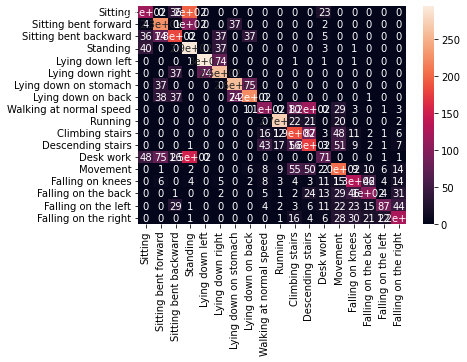

In [101]:
import seaborn as sns
sns.heatmap(confusion_matrix, annot=True, xticklabels=class_labels.keys(), yticklabels=class_labels.keys())

### Save a test intance

In [33]:
for i in range(5):
    np.savetxt('data/test_instance' + str(i) + '.txt', X_test[i])

In [34]:
for i in np.arange(15,20):
    print(y_test[i])
    np.savetxt('data/test_instance' + str(i) + '.txt', X_test[i])

[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]


## Save to file and convert to tflite

In [25]:
# Saving the model to file
model_name = 'cnn_lyingback_running'

export_dir = 'models\' + model_name
tf.saved_model.save(model,export_dir)

# Convert the saved tensorflow model to tensorflow lite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

# Save the tensorflow lite model to file
import pathlib
tflite_model_file = pathlib.Path('models/' + model_name + '.tflite')
tflite_model_file.write_bytes(tflite_model)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: models\cnn_walking_standing\assets


1234796